# Code for CUQIpy paper 1, section 3

In [1]:
import cuqi
import numpy as np
import matplotlib.pyplot as plt

from cuqi.testproblem import Deconvolution1D, Deconvolution2D
from cuqi.distribution import Gaussian, Gamma, GMRF, Laplace_diff, Cauchy_diff, JointDistribution
from cuqi.problem import BayesianProblem
from cuqi.sampler import CWMH, MALA, UnadjustedLaplaceApproximation

print(f"cuqipy version: {cuqi.__version__}")

# Options
s = 0.01 # Noise standard deviation
seed = 4 # Random seed

cuqipy version: 0+untagged.2508.g2d277b2


## 3.1-3.3 Basics

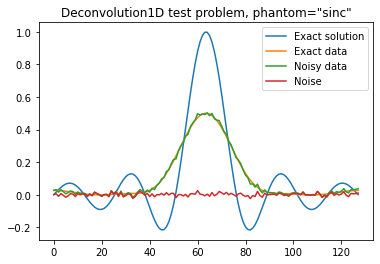

In [2]:
np.random.seed(seed)

A, y_data, info = Deconvolution1D.get_components(phantom='sinc', noise_std=s)

x_true = info.exactSolution
y_true = info.exactData

x_true.plot(label="Exact solution")
y_true.plot(label="Exact data")
y_data.plot(label="Noisy data")
(y_data-y_true).plot(label="Noise")

ax = plt.gca()
ylims = ax.get_ylim()
plt.title("Deconvolution1D test problem, phantom=\"sinc\"")
plt.legend()

In [3]:
# Demonstrate forward and adjoint
yx = A @ x_true
xx = A.T(yx)

In [4]:
m = A.range_dim
n = A.domain_dim
x_zero = np.zeros(n)

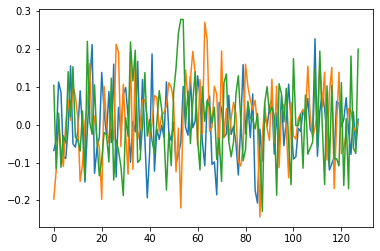

In [5]:
x = Gaussian(x_zero, 0.1**2)
samples_x = x.sample(3)
samples_x.plot()

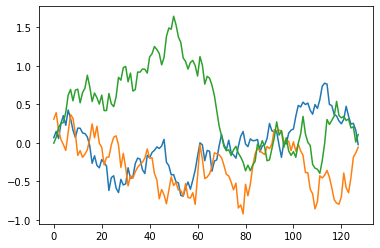

In [6]:
x = GMRF(x_zero, 50)
samples_x = x.sample(3)
samples_x.plot()

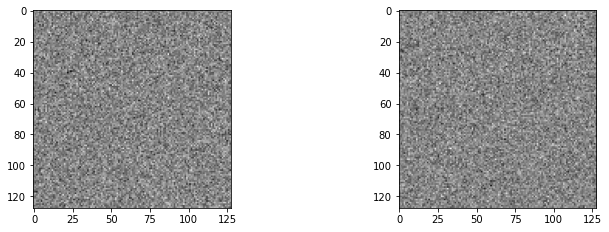

In [7]:
x = Gaussian(np.zeros(128**2), 0.1**2, geometry=cuqi.geometry.Image2D((128, 128)))
samples_x = x.sample(2)
samples_x.plot()

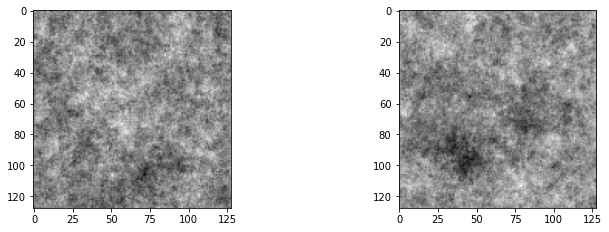

In [8]:
x = GMRF(np.zeros(128**2), 50, physical_dim=2)
samples_x = x.sample(2)
samples_x.plot()

## 3.4 Bayesian modelling 

In [9]:
x = GMRF(x_zero, 50)  
y = Gaussian(A@x, s**2)

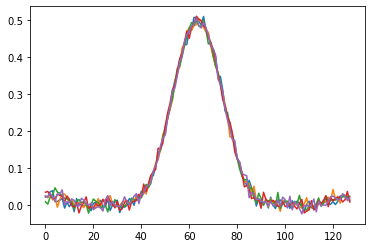

In [10]:
y(x=x_true).sample(5).plot()

In [11]:
BP = BayesianProblem(y, x)
print(BP)

BayesianProblem with target: 
 JointDistribution(
    Equation: 
	p(y,x) = p(y|x)p(x)
    Densities: 
	y ~ CUQI Gaussian. Conditioning variables ['x'].
	x ~ CUQI GMRF.
)


In [12]:
BP.set_data(y=y_data)

BayesianProblem with target: 
 Posterior(
    Equation:
	 p(x|y) ∝ L(x|y)p(x)
    Densities:
	y ~ CUQI Gaussian Likelihood function. Parameters ['x'].
 	x ~ CUQI GMRF.
 )

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic solver selection is experimental. !!!
!!!    Always validate the computed results.    !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Optimizing with exact gradients
Using scipy.optimize.minimize on negative log of Likelihood
x0: ones vector
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic solver selection is experimental. !!!
!!!    Always validate the computed results.    !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Optimizing with exact gradients
Using scipy.optimize.minimize on negative log of Posterior
x0: ones vector


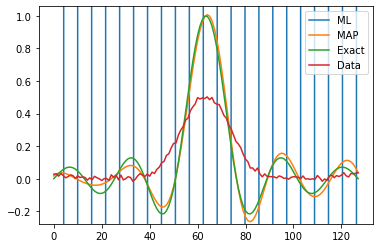

In [13]:
x_ML = BP.ML()
x_MAP = BP.MAP()

x_ML.plot()
x_MAP.plot()
x_true.plot()
y_data.plot()
plt.ylim(ylims)
plt.legend(("ML", "MAP", "Exact", "Data"))

In [14]:
samples = BP.sample_posterior(1000)

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic sampler selection is experimental. !!!
!!!    Always validate the computed results.     !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Using Linear_RTO sampler.
burn-in: 20%
Sample 1200 / 1200
Elapsed time: 4.282991886138916


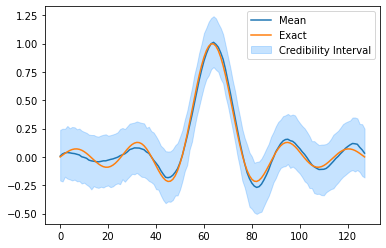

In [15]:
samples.plot_ci(exact=x_true)

## 3.5 Hierarchical modelling

Computing 1000 samples
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic sampler selection is experimental. !!!
!!!    Always validate the computed results.     !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Using Gibbs sampler
burn-in: 20%

Automatically determined sampling strategy:
	x: Linear_RTO
	s: Conjugate

Warmup 200 / 200
Sample 1000 / 1000
Elapsed time: 7.850998640060425
Plotting results


{'x': <cuqi.samples._samples.Samples at 0x1fdd0f2dee0>,
 's': <cuqi.samples._samples.Samples at 0x1fdd0f2d790>}

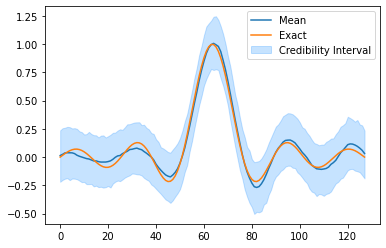

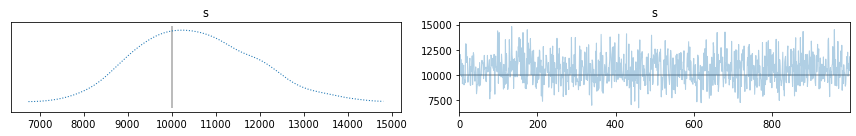

In [16]:
s = Gamma(1, 1e-4)
x = GMRF(x_zero, 50)
y = Gaussian(A@x, prec=lambda s: s)

BP = cuqi.problem.BayesianProblem(y, x, s)
BP.set_data(y=y_data)

BP.UQ(1000, exact={"x": x_true, "s": 1/0.01**2})